In [1]:
#DATA EXPLORATION

In [2]:
import os #thư viện tương tác với hệ điều hành
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

import cv2


In [3]:
#tính tổng số class và tổng số image và số image trong mỗi class
dataset = 'pollen' #/pollen_dataset
total =0
classes={} #dictionary với key và value

for class_name in os.listdir(dataset):
    class_path= os.path.join(dataset, class_name) #/pollen_dataset/01_bang_lang ..

    if os.path.isdir(class_path):
        num_image = len(os.listdir(class_path)) #số ảnh trong từng class
        total +=num_image
        classes[class_name]=num_image

print(f"Total image: {total}")
print(f"Number of classes: {len(os.listdir(dataset))}")
print(classes)

Total image: 5322
Number of classes: 22
{'04_cai_be_xanh': 69, '20_khe': 212, '19_hung_tay': 178, '08_cuc_van_tho_phap': 247, '01_bang_lang': 216, '18_hong_xiem': 242, '12_du_du': 401, '22_lan_y': 203, '21_lac': 211, '11_dau_da_xoan': 223, '05_cai_cuc': 252, '17_hoa_muoi_gio': 206, '10_dam_but': 160, '14_hoa_dao': 139, '15_hoa_giay': 593, '02_buoi': 223, '03_ca_chua': 489, '06_cat_sam': 275, '09_cut_lon': 189, '16_hoa_hong': 181, '13_gao': 210, '07_cau': 203}


Note: you may need to restart the kernel to use updated packages.


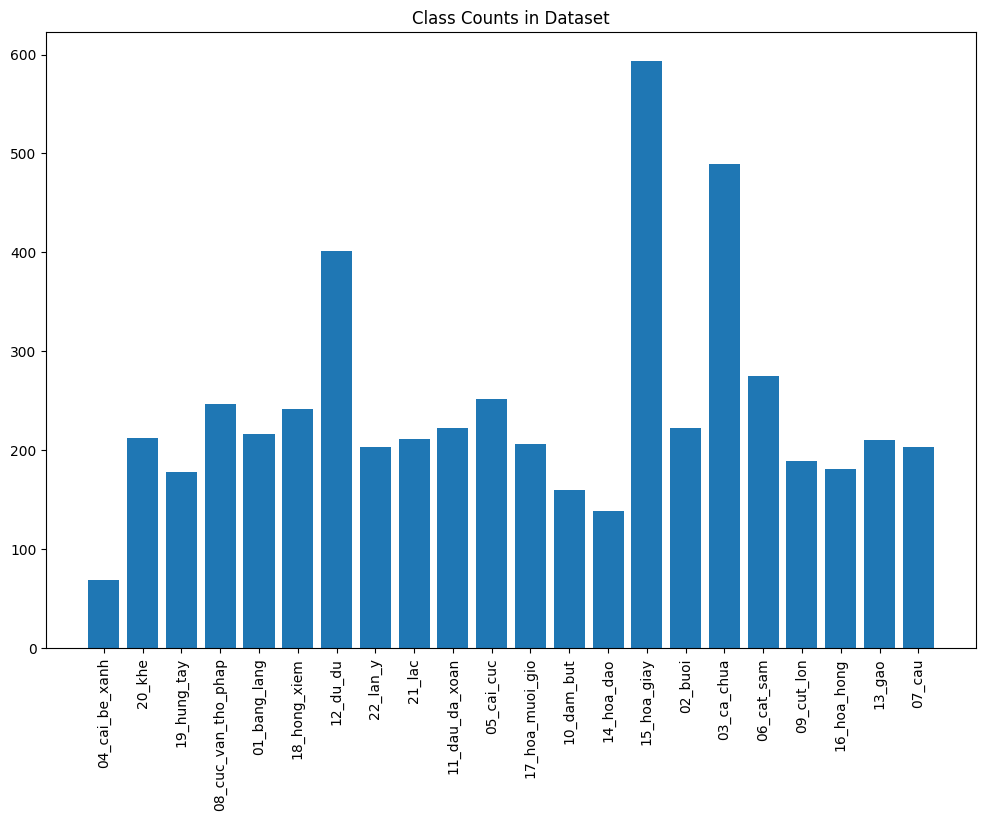

In [4]:
%pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.title('Class Counts in Dataset')
#plt.bar(*zip(*classes.items())) #graph of class v count data
plt.bar(classes.keys(), classes.values())  # Lấy key là tên loài, value là số ảnh
plt.xticks(rotation='vertical')
plt.show()

In [5]:
#in ra vài ảnh sample của mỗi lớp
classes = {}

for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset,class_name)
    classes[class_name] = []
    for image in os.listdir(class_path):
        image_path= os.path.join(class_path,image)
        if os.path.isfile(image_path):
            classes[class_name].append(image_path) #nhét đường dẫn của ảnh vào dictionary
            
#     'class_1': ['/path/to/dataset/class_1/img1.jpg', '/path/to/dataset/class_1/img2.jpg'],
#     'class_2': ['/path/to/dataset/class_2/img3.jpg', '/path/to/dataset/class_2/img4.jpg']
# }
        

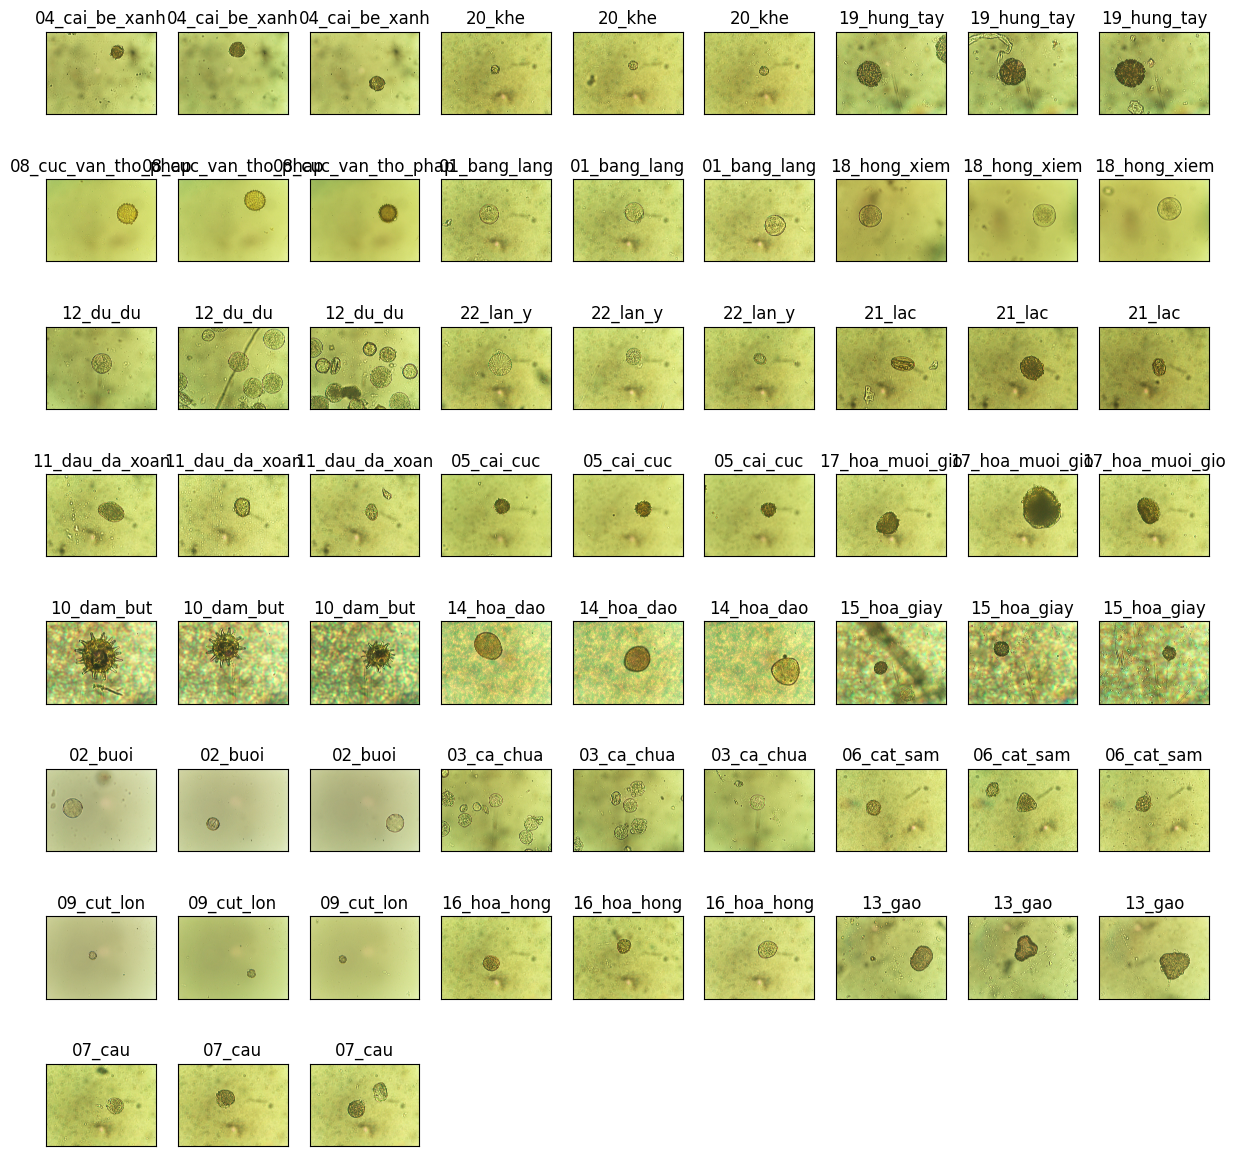

In [6]:
fig = plt.figure(figsize=(15, 15))
for i, key in enumerate(classes.keys()):
    img1 = plt.imread(classes[key][0]) #opens first three images of each class by link
    img2 = plt.imread(classes[key][1])
    img3 = plt.imread(classes[key][2])

    ax = fig.add_subplot(8, 9,  3*i + 1, xticks=[], yticks=[])
    ax.imshow(img1)
    ax.set_title(key)

    ax = fig.add_subplot(8, 9,  3*i + 2, xticks=[], yticks=[])
    ax.imshow(img2)
    ax.set_title(key)

    ax = fig.add_subplot(8, 9,  3*i + 3, xticks=[], yticks=[])
    ax.imshow(img3)
    ax.set_title(key)

plt.show()

In [7]:
#PREPROCESSING AND SPLITING DATA

In [8]:
def process_img(img, size = (224,224)):
    img = cv2.resize(img, size)  # resize image
    img = img/255                   # normalize image
    return img

In [9]:
import numpy as np

import cv2
X, Y = [], []    

for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset,class_name)

    for image in os.listdir(class_path):
        image_path= os.path.join(class_path,image)
        img = cv2.imread(image_path)
        if img is not None:  # Check if the image was loaded successfully
            X.append(process_img(img))
            Y.append(class_name)
        else:
            print(f"Warning: Could not read image {image_path}")


X = np.array(X)
Y = np.array(Y)

print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))


Number of samples in X: 5322
Number of samples in Y: 5322


In [10]:
import joblib
joblib.dump(X, 'X_data.pkl') #lưu lại X và Y để dùng, k cần phải chạy lại code trên vào lần sau
joblib.dump(Y, 'Y_data.pkl')

['Y_data.pkl']

In [11]:
X = joblib.load('X_data.pkl') #load X,Y
Y = joblib.load('Y_data.pkl')

In [12]:
%pip install scikit-learn   
%pip install setuptools



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
Y_le = le.fit_transform(Y)
Y_cat = to_categorical(Y_le, 22)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_cat, test_size=0.2, stratify=Y_le)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, stratify=Y_test)
print("Images in each class in Test set: {}".format(np.sum(Y_test, axis =0)))

Images in each class in Test set: [22. 22. 49.  7. 25. 27. 21. 24. 19. 16. 22. 40. 21. 14. 59. 18. 21. 24.
 18. 21. 21. 21.]


In [44]:
import joblib
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(Y_test, 'Y_test.pkl')

['Y_test.pkl']

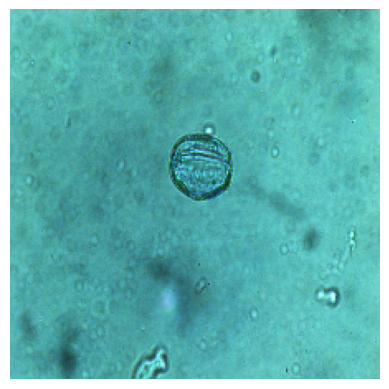

In [15]:
# Hiển thị một ảnh gốc từ X_train
import matplotlib.pyplot as plt
plt.imshow(X_train[0])  # Hiển thị ảnh đầu tiên trong X_train
plt.axis('off')
plt.show()



In [16]:
#DATA AUGMENTATION AND SMOTE

In [17]:
import tensorflow as tf

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range= 20,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                horizontal_flip = True,
                vertical_flip = True,
                
                )
# fitting the data generator
data_generator.fit(X_train) 

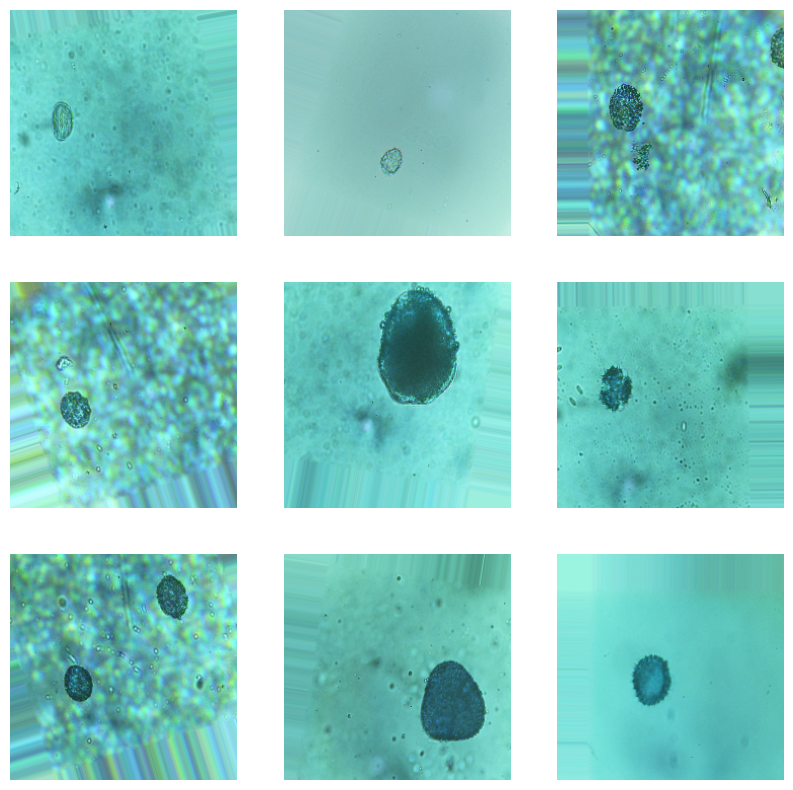

In [18]:
import matplotlib.pyplot as plt
#Hiển thị ảnh sau augmentation
# Tạo generator từ X_train và Y_train

train_generator = data_generator.flow(X_train, Y_train, batch_size=16)

# Lấy một batch ảnh từ train_generator
x_batch, y_batch = next(train_generator)

# Hiển thị một số ảnh trong batch
plt.figure(figsize=(10, 10))
for i in range(9):  # Hiển thị 9 ảnh trong batch
    plt.subplot(3, 3, i+1)
    img = x_batch[i]  # Ảnh đã chuẩn hóa trong phạm vi [0, 1]
    plt.imshow(img)  # Hiển thị ảnh
    plt.axis('off')  # Tắt trục tọa độ
plt.show()


In [19]:
#MODEL DENSENET121

In [20]:
import tensorflow as tf
import requests
import os

# Download the weights file manually
weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_path = "densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"

if not os.path.exists(weights_path):
    response = requests.get(weights_url, verify=False)
    with open(weights_path, 'wb') as f:
        f.write(response.content)

pretrained_model = tf.keras.applications.DenseNet121(
    include_top=False, # include only the convolutional layers that do the feature extraction, drop fully connected layer
    weights=weights_path,
    input_shape=(224,224,3), #size 128x128, 3 channel 
)

In [21]:
pretrained_model.trainable = False #freeze all layers (weight and parameter unchange)

In [22]:
model = tf.keras.models.Sequential() #sequential model
model.add(pretrained_model) #first layers
model.add(tf.keras.layers.GlobalAveragePooling2D()) # convert to 1 dimension vector
model.add(tf.keras.layers.Dropout(0.2)) # drop 20% neural in the prev layer, reduce overfitting
model.add(tf.keras.layers.Dense(500, activation = 'relu')) #fully connected layer, 500 neural, activation func relu
model.add(tf.keras.layers.Dense(150, activation = 'relu')) #like above
model.add(tf.keras.layers.Dense(22, activation = 'softmax')) #output with 22 neural ~ 22 classes pollen, activation func softmax (0-1)
model.summary() #in ra cai bang duoi

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       512,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        75,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │         3,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,628,476 (29.10 MB)

 Trainable params: 590,972 (2.25 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [23]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
batch_size = 16
epoch=100

model_path = 'densenet.keras'
callbecks = [tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience = 60),
             tf.keras.callbacks.ModelCheckpoint(filepath = model_path, save_best_only = True)]

history = model.fit(
        data_generator.flow(X_train, Y_train, batch_size=batch_size),
        batch_size = batch_size,
        epochs = epoch,
        validation_data = (X_val, Y_val),
        callbacks = callbecks,
        verbose = 1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.5181 - loss: 1.7004 - val_accuracy: 0.8630 - val_loss: 0.4111
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.8080 - loss: 0.5894 - val_accuracy: 0.8912 - val_loss: 0.3223
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8539 - loss: 0.4447 - val_accuracy: 0.8574 - val_loss: 0.3990
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.8759 - loss: 0.3761 - val_accuracy: 0.9250 - val_loss: 0.2546
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.8684 - loss: 0.3940 - val_accuracy: 0.9268 - val_loss: 0.2222
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.8785 - loss: 0.3772 - val_accuracy: 0.9156 - val_loss: 0.2469
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.8866 - loss: 0.3377 - val_accuracy: 0.8987 - val_loss: 0.3439
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9012 - loss: 0.3104 - 

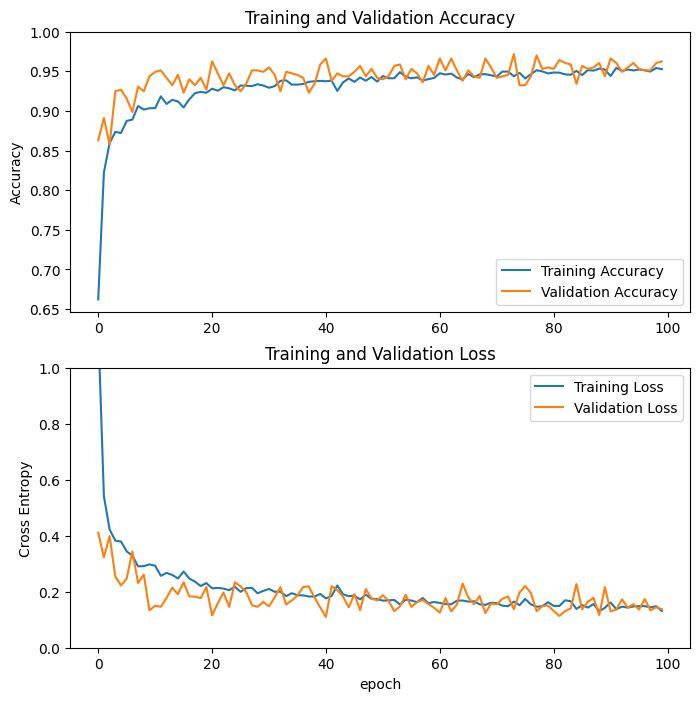

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
model.load_weights('densenet.keras')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test set accuracy: {}'.format(score[1]))

Test set accuracy: 0.9680451154708862


In [36]:
from tensorflow.keras.models import load_model

model = load_model("densenet.keras")

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


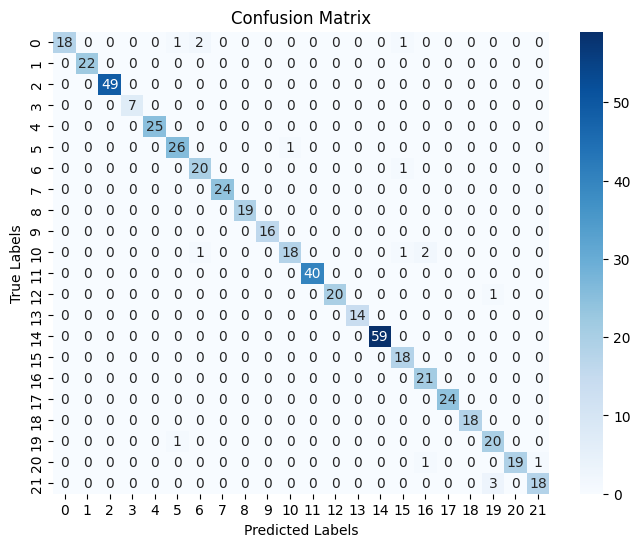

[[18  0  0  0  0  1  2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 26  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0 18  0  0  0  0  1  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Dự đoán xác suất từ mô hình
Y_pred = model.predict(X_test)

# Chuyển đổi xác suất thành nhãn lớp (chỉ số lớp có xác suất cao nhất)
Y_pred_classes = Y_pred.argmax(axis=1)
Y_test_classes = Y_test.argmax(axis=1)

# Tính toán ma trận nhầm lẫ
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(22), yticklabels=range(22))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# In ma trận nhầm lẫn
print(conf_matrix)


In [38]:
from sklearn.metrics import classification_report

report = classification_report(Y_test_classes, Y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        25
           5       0.93      0.96      0.95        27
           6       0.87      0.95      0.91        21
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        16
          10       0.95      0.82      0.88        22
          11       1.00      1.00      1.00        40
          12       1.00      0.95      0.98        21
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        59
          15       0.86      1.00      0.92        18
          16       0.88      1.00      0.93        21
          17       1.00    

03_ca_chua


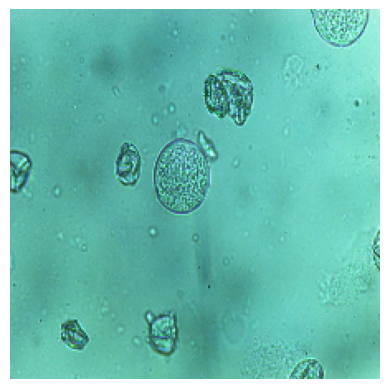

In [45]:
import random
import matplotlib.pyplot as plt

# Random chọn một ảnh từ X_test
i = random.randint(0, len(X_test) - 1)  # Chọn một index ngẫu nhiên
random_image = X_test[i]               # Lấy ảnh từ X_test
random_class=Y_test[i]

true_class=np.argmax(random_class)
label=le.inverse_transform([true_class])[0]
print(label)

# Hiển thị ảnh
#plt.figure(figsize=(5, 5))
plt.imshow(random_image)  # Hiển thị ảnh
plt.axis('off')  # Tắt trục tọa độ
plt.show()


In [43]:
#predict trong tập test
model = load_model("densenet.keras")
random_image_batch = np.expand_dims(random_image, axis=0)  # Thêm batch dimension

# Dự đoán
predictions = model.predict(random_image_batch)

# Hiển thị kết quả dự đoán
print("Predictions:", predictions)

# Lấy lớp có xác suất cao nhất (nếu cần)
predicted_class = np.argmax(predictions)
predicted_label = le.inverse_transform([predicted_class])[0]

print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predictions: [[4.2637053e-14 3.0042906e-13 9.9999619e-01 1.9670892e-09 9.3190077e-14
  2.8649422e-10 4.1382669e-14 1.2953217e-14 2.9534192e-12 4.4766314e-15
  9.8352519e-14 3.7066200e-06 1.5504117e-11 4.5538662e-10 9.5315211e-15
  6.0220927e-08 4.0893173e-16 1.2383314e-10 1.4507456e-12 1.1958593e-12
  5.3289634e-15 4.3744744e-11]]
03_ca_chua


In [33]:
#predict ngoài tập test
model = load_model("densenet.keras")
image='ex8.jpg'
img = cv2.imread(image)
if img is not None:
	pre_img = process_img(img)
	pre_img = np.expand_dims(pre_img, axis=0)

	prediction = model.predict(pre_img)
	print("Predictions:", prediction)

	# Lấy lớp có xác suất cao nhất (nếu cần)
	predicted_class = np.argmax(prediction)
	predicted_label = le.inverse_transform([predicted_class])[0]
	confidence = prediction[0][predicted_class]

	print(predicted_label)
	print(f"Confidence: {confidence:.2f}")
else:
	print(f"Error: Could not read image {image}")

Error: Could not read image ex8.jpg


[ WARN:0@53273.891] global loadsave.cpp:241 findDecoder imread_('ex8.jpg'): can't open/read file: check file path/integrity
